<a href="https://colab.research.google.com/github/AlbezJelt/compass-aligned-graph-embeddings/blob/main/notebooks/Cade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install folium==0.2.1
!pip install git+https://github.com/valedica/gensim.git
!pip install -U cade

In [2]:
%%capture
#download file.txt
!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wiki_walks_from_dbpedia.txt
!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wikidata_walks_final.txt
#compass.txt for cade
!cat wiki_walks_from_dbpedia.txt wikidata_walks_final.txt >> compass.txt

In [3]:
import json
import requests
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine

In [4]:
#load dictionary with labels
with requests.get("https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wikidata_label_dictionary.json", "rt") as req:
  label_dict = json.loads(req.text)

In [5]:
#train compass
aligner = CADE(size=30)
aligner.train_compass("compass.txt", overwrite=False)

Training the compass from scratch.


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
#train 2 slices on texts
slice_one = aligner.train_slice("wiki_walks_from_dbpedia.txt", save=True)
slice_two = aligner.train_slice("wikidata_walks_final.txt", save=True)

Training embeddings: slice wiki_walks_from_dbpedia.txt.


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.
Training embeddings: slice wikidata_walks_final.txt.
Initializing embeddings from compass.


In [7]:
#create models for texts
model1 = Word2Vec.load("model/wiki_walks_from_dbpedia.model")
model2 = Word2Vec.load("model/wikidata_walks_final.model")

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [27]:
def graph_creation(startpoint, epoch):
  if epoch == 0:
    return 0
  similar_db_wi = model2.wv.similar_by_vector(model1[startpoint])[slice(0,3)]
  similar_wi_db = model1.wv.similar_by_vector(model2[startpoint])[slice(0,3)]
  similar = similar_db_wi + similar_wi_db
  if startpoint not in G:
      G.add_node(label_dict[startpoint], pos)
  for i in similar:
    if i[0] in model1.wv.vocab and i[0] in model2.wv.vocab:
      word = label_dict[i[0]]
      weight = i[1]
      edge = (label_dict[startpoint], word)
      if word not in G:
        G.add_node(word)
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_creation(i[0], epoch-1)

  return 0

In [41]:
import networkx as nx
G=nx.DiGraph(directed = True)
startpoint = "Q38"
graph_creation(startpoint, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


0

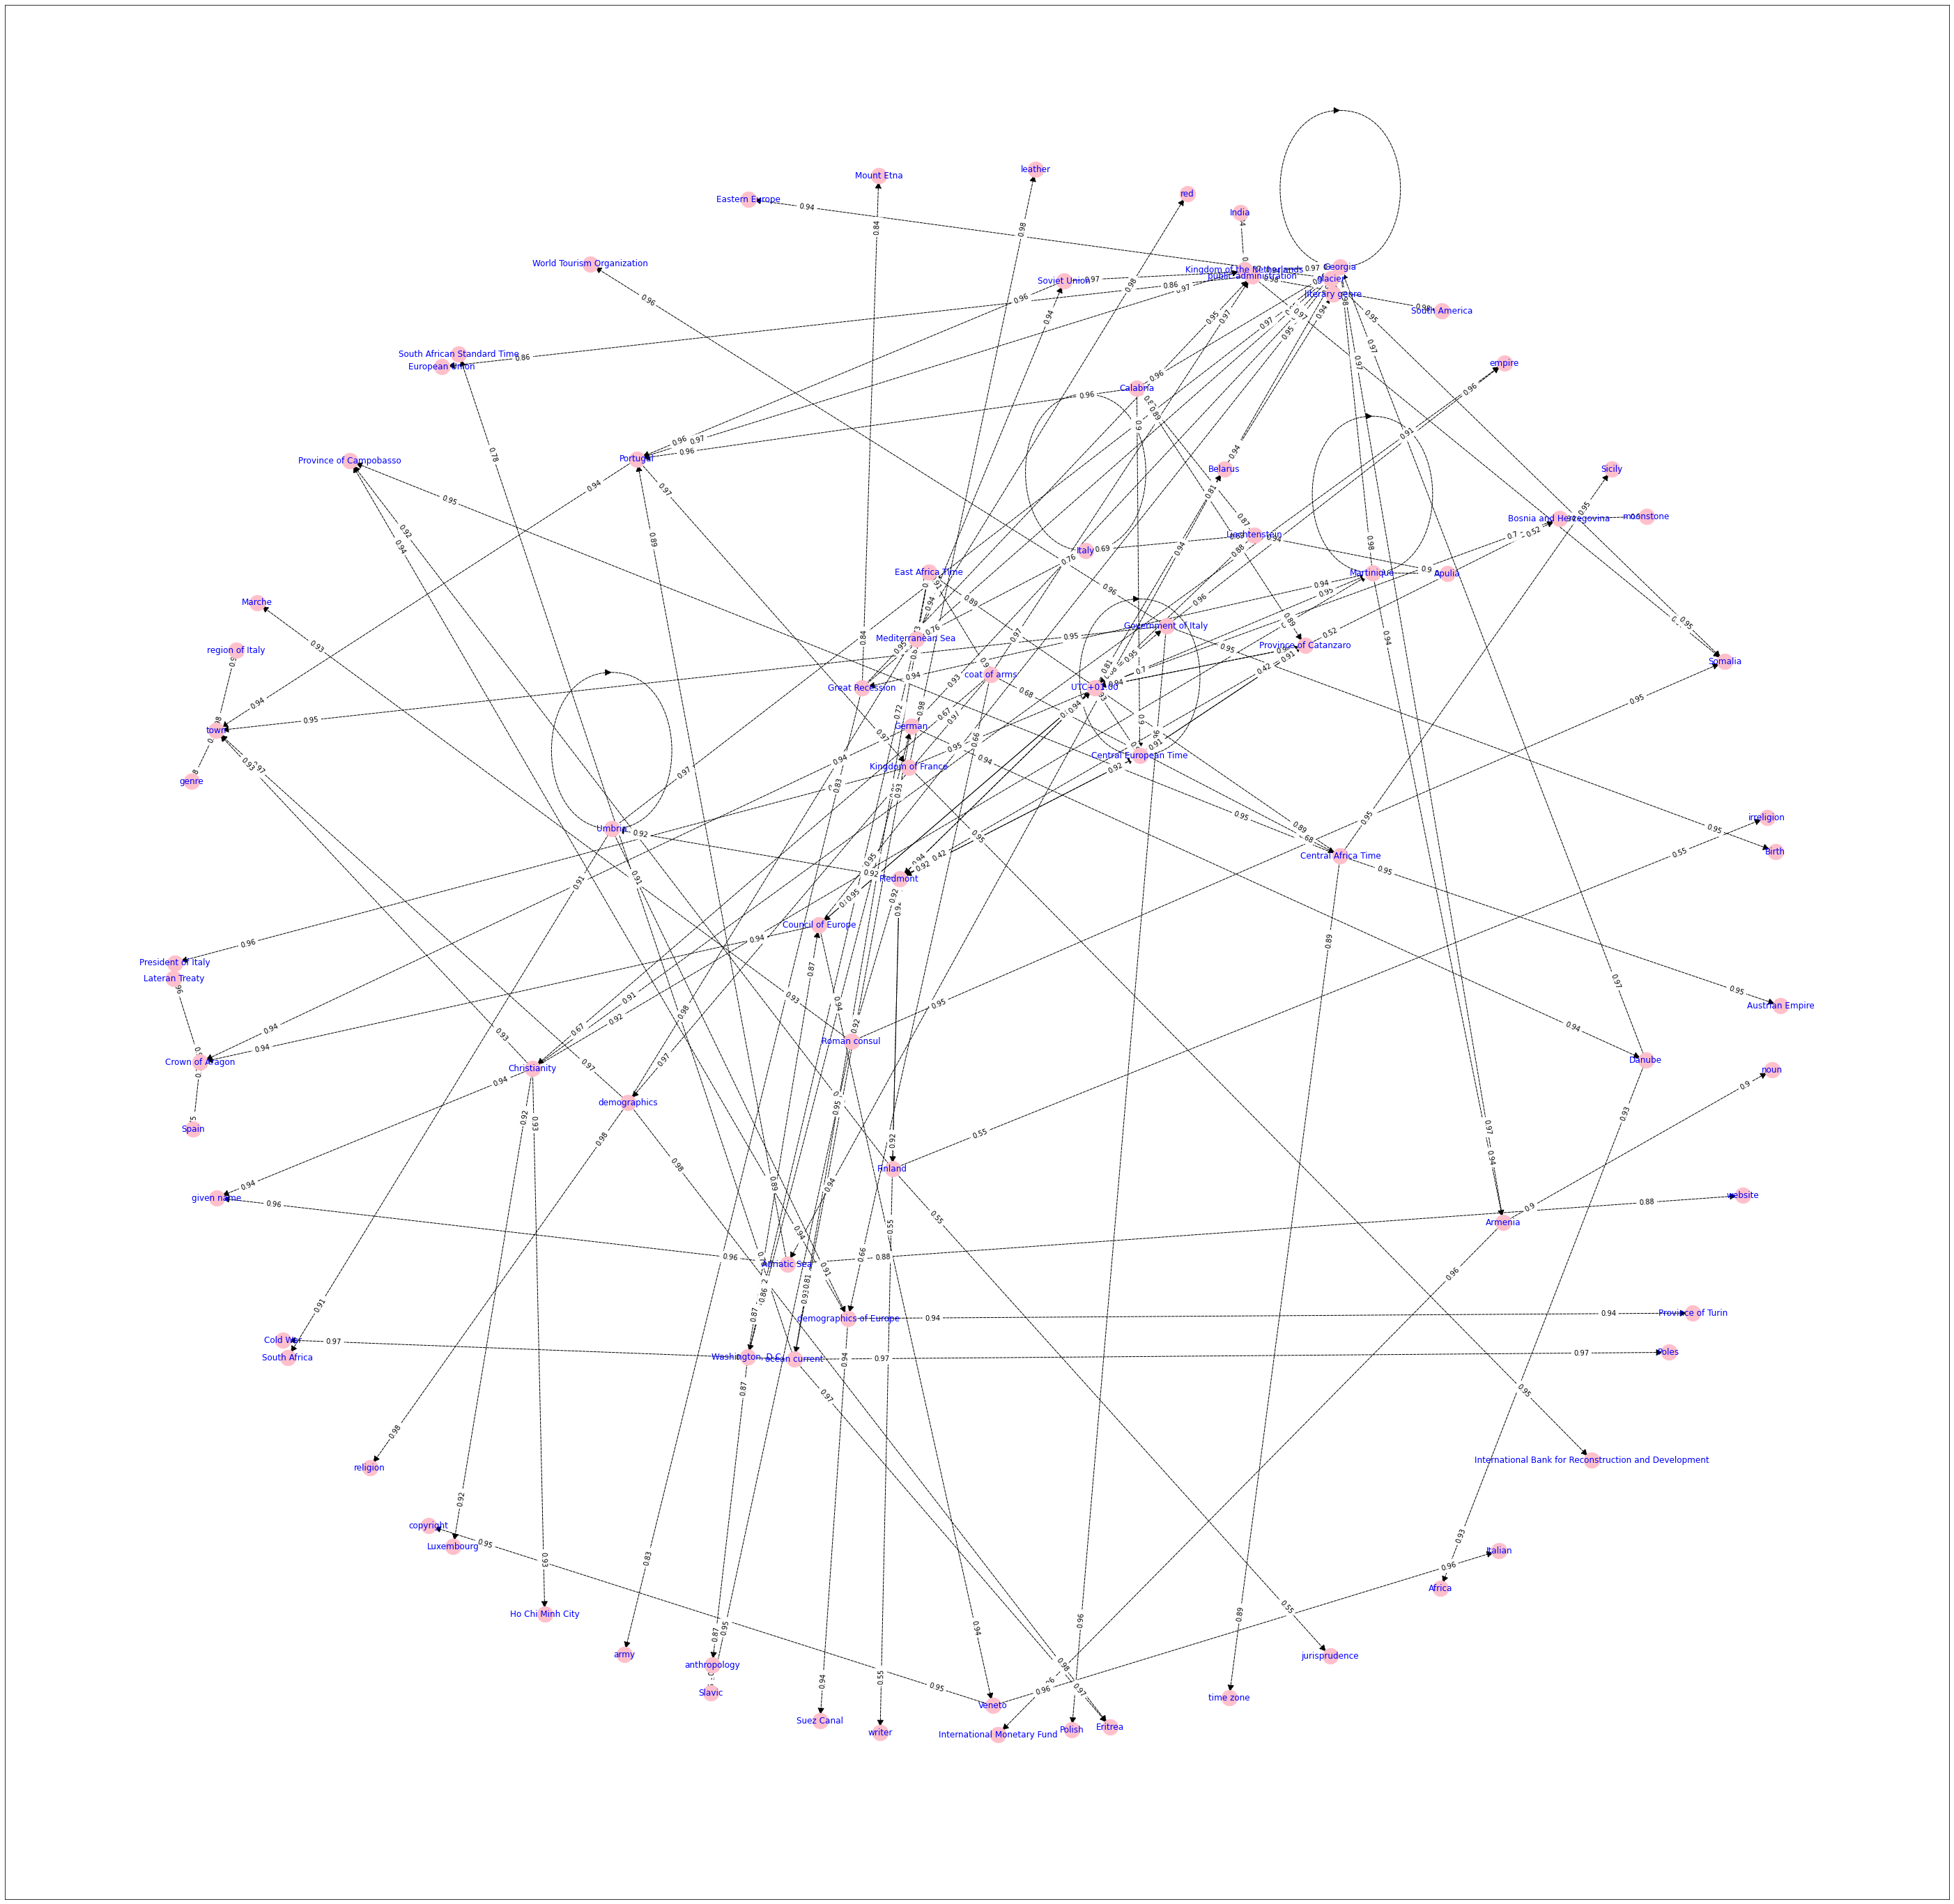

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
pos = nx.spring_layout(G, center = (0,0))
for i in pos:
  #pos[i][0] = (pos[i][0]) * 10 # x coordinate
  #pos[i][1] = (pos[i][1]) * 10 # y coordinate
  distance = (pos[i][0]**2+pos[i][1]**2)**(1/2)
  pos[i][0] = (pos[i][0]) * (3**(11-distance))
  pos[i][1] = (pos[i][1]) * (3**(11-distance))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='pink')
nx.draw_networkx_edges(G, pos, arrows = True, arrowsize=20, style='dashed')
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.1)
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.9)
nx.draw_networkx_labels(G, pos, font_color="blue")
plt.show()

In [53]:
%%capture
!pip install pyvis


In [55]:
from pyvis.network import Network
from IPython.core.display import display, HTML
net = Network(notebook=True)
net.from_nx(G)
net.show_buttons(filter_="physics")
net.show("net.html")
display(HTML('net.html'))

